# ResNet50 model

### ResNet50 with only 2 categories (Benign and Malign)

## Get packages

In [10]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm
import albumentations as A
import cv2

from skimage.io import imread
from skimage.io import imshow
from skimage.util import crop
from skimage.transform import resize
import matplotlib.pyplot as plt


from tensorflow import keras
from tensorflow.keras.utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras import models
from keras.preprocessing import image

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# model / neural network
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.python.framework import ops
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback

## Paths

In [88]:
TRAIN_PATH = 'archive/classification/binary/no_frame/balance/train'
TEST_PATH = 'archive/classification/binary/no_frame/balance/test' 
VALID_PATH = 'archive/classification/binary/no_frame/balance/validate'

In [44]:
input_size = (3,224,224)

## Load and Prepare Images

In [89]:
from keras.preprocessing.image import ImageDataGenerator

# # for neaug
# # divisible with 259: 7, 37
# train_batchsize = 37
# # divisible with 51: 3, 17 
# valid_batchsize = 17


# #for aug
# # divisible with 518:  2, 259.
# train_batchsize = 2
# # divisible with 51: 3, 17 
# valid_batchsize = 3


# #for balance
# # divisible with 494: 2, 7, 14, 31, 62, 217
# train_batchsize = 7
# # divisible with 18: 2, 3, 6, 9
# valid_batchsize = 6


# # for neaug non-frame
# # divisible with 253: 11, 23 
# train_batchsize = 23
# # divisible with 50: 2, 5, 10, 25,
# valid_batchsize = 5


# #for aug non-frame
# # divisible with 506: 2, 11, 22, 23, 46, 253,
# train_batchsize = 22
# # divisible with 50: 2, 5, 10, 25,
# valid_batchsize = 5


#for balance non-frame
# divisible with 422: 2, 211.
train_batchsize = 2
# divisible with 16: 2, 4, 8,
valid_batchsize = 4

train_datagen = ImageDataGenerator(  rescale = 1./255.
)

validation_datagen = ImageDataGenerator(  rescale = 1./255.)
                                  

train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,  
        shuffle=True,
         batch_size=train_batchsize,
        target_size=input_size[1:],
        class_mode='categorical')  

validation_generator = validation_datagen.flow_from_directory(
        VALID_PATH,  
        target_size=input_size[1:],
        shuffle=True,
         batch_size=valid_batchsize,
        class_mode='categorical')


Found 422 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Import the Model

### Pre-trained

In [90]:
from tensorflow.keras.applications.resnet50 import ResNet50
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = False

### Adjust the model

In [91]:
# We need to change the final layer accoding to the number of classes we have
model = Sequential()
model.add(base_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(512, kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
          
model.add(Dense(256, kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
          
model.add(Dense(128, kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
          
model.add(Dense(64,kernel_regularizer=regularizers.l2(0.01)))  
model.add(Activation('relu'))
model.add(Dropout(0.5))
          
model.add(Dense(2, activation='softmax'))  

# Print a summary of the model architecture
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_25 (Dense)            (None, 512)               1049088   
                                                                 
 activation_20 (Activation)  (None, 512)               0         
                                                                 
 dropout_20 (Dropout)        (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 256)               131328    
                                                      

In [92]:

model.compile(
    loss = keras.losses.BinaryFocalCrossentropy(),
   optimizer=keras.optimizers.legacy.RMSprop(learning_rate=0.001,decay=1e-3, momentum=0.9),
    metrics = ['accuracy']
)

## Train the model

In [93]:
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.Variable) or tf.is_tensor(lr):
            lr = tf.keras.backend.get_value(lr)
        print(f" Epoch {epoch+1}: Learning rate is {lr:.6f}")

In [94]:
# Se antreneaza modelul
checkpoiter = keras.callbacks.ModelCheckpoint('model_resnet_simple.h5', verbose=1, save_best_only=True)

steps = train_generator.samples//train_generator.batch_size
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=4, min_lr=0.00001, verbose=1)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    keras.callbacks.TensorBoard(log_dir='logs'),
    reduce_lr,
    LearningRateLogger(),
    checkpoiter

]

results = model.fit(train_generator, 
                    validation_data=validation_generator, 
                    steps_per_epoch = steps,
                    shuffle=True,
                    epochs=50, 
                    callbacks=callbacks,
                    verbose=1
                   )


Epoch 1/50
211/211 [==============================] - ETA: 0s - loss: 2.8893 - accuracy: 0.4526 Epoch 1: Learning rate is 0.001000

Epoch 1: val_loss improved from inf to 0.19831, saving model to model_resnet_simple.h5


/Users/taras_lara/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


211/211 [==============================] - 62s 277ms/step - loss: 2.8893 - accuracy: 0.4526 - val_loss: 0.1983 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/50
211/211 [==============================] - ETA: 0s - loss: 0.1787 - accuracy: 0.4360 Epoch 2: Learning rate is 0.001000

Epoch 2: val_loss improved from 0.19831 to 0.17336, saving model to model_resnet_simple.h5
211/211 [==============================] - 78s 372ms/step - loss: 0.1787 - accuracy: 0.4360 - val_loss: 0.1734 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/50
211/211 [==============================] - ETA: 0s - loss: 0.1746 - accuracy: 0.4787 Epoch 3: Learning rate is 0.001000

Epoch 3: val_loss did not improve from 0.17336
211/211 [==============================] - 76s 360ms/step - loss: 0.1746 - accuracy: 0.4787 - val_loss: 0.1734 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/50
211/211 [==============================] - ETA: 0s - loss: 0.1741 - accuracy: 0.4787 Epoch 4: Learning rate is 0.001000

Epoch 4: val_loss improve

## Results

In [95]:
print('Accuracy Score = ',np.max(results.history['val_accuracy']))
print('Loss Score = ',np.min(results.history['val_loss']))

Accuracy Score =  0.5
Loss Score =  0.17331455647945404


### During training

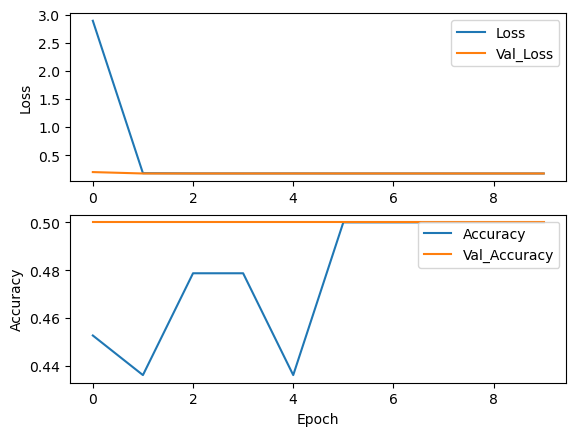

In [97]:
plt.figure()
plt.subplot(211)
loss_train_curve = results.history["loss"]
loss_val_curve = results.history["val_loss"]
plt.plot(loss_train_curve, label = "Loss")
plt.plot(loss_val_curve, label = "Val_Loss")
plt.legend(loc = 'upper right')
plt.ylabel("Loss")


plt.subplot(212)
acc_train_curve = results.history["accuracy"]
acc_val_curve = results.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Accuracy")
plt.plot(acc_val_curve, label = "Val_Accuracy")
plt.legend(loc = 'upper right')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

### Test the model

In [98]:

# divisible with 36: 2, 3, 4, 6, 9, 12, 18
test_batch_size = 3


test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=input_size[1:],
    batch_size=test_batch_size,
    shuffle=False,
class_mode='categorical')

scores = model.evaluate(test_generator,workers=12)
target_names = list(test_generator.class_indices.keys())

Found 36 images belonging to 2 classes.
12/12 [==============================] - 7s 602ms/step - loss: 0.1704 - accuracy: 0.8056


### Make predictions

In [99]:
test_generator.reset()

Y_pred = model.predict(test_generator, verbose=1)

y_pred = np.argmax(Y_pred, axis=-1)
classes = test_generator.classes

print(classes)
print(y_pred)

print(sum(y_pred==classes)/len(test_generator.classes))

12/12 [==============================] - 9s 570ms/step
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.8055555555555556


### Confusion Matrix

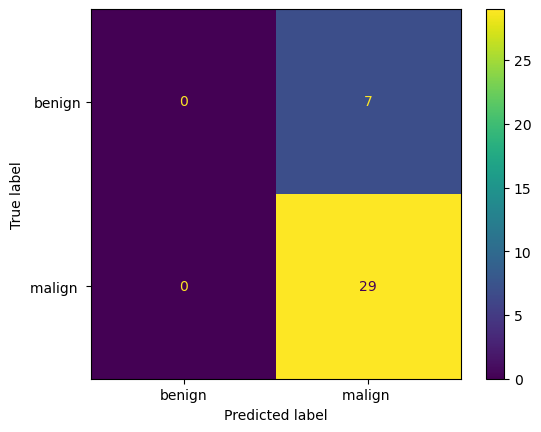

In [100]:

cm = confusion_matrix(classes, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot()
plt.grid(False)
plt.show()

### Metrics

In [101]:
TN, FP, FN, TP = cm.ravel()


In [102]:
print("True positive=",TP)
print("True Negative=",TN)
print("False positive=",FP)
print("False Negative=",FN)

True positive= 29
True Negative= 0
False positive= 7
False Negative= 0


In [104]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
#F1_SCORE
FSCO=(2*TP) / ((2*TP) +FP + FN) 
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

/var/folders/ml/1pq8pf157qjcrdxwm5xjgzfm0000gn/T/ipykernel_2586/1327457140.py:8: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN/(TN+FN)


In [105]:
print("sensitivity=",round(TPR*100,3),"%")
print("precision=",round(PPV*100,3),"%")
print("Specificity=",round(TNR*100,3),"%")
print("F-score=", round(FSCO*100,3),"%")
print("ACCURACY=",round(ACC*100,3),"%")
print("FNR=",FNR*100,"%")
print("FPR=",FPR*100,"%")
print("NPV=",NPV*100,"%")

sensitivity= 100.0 %
precision= 80.556 %
Specificity= 0.0 %
F-score= 89.231 %
ACCURACY= 80.556 %
FNR= 0.0 %
FPR= 100.0 %
NPV= nan %
